In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
%matplotlib inline

import zipfile

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import CalendarFourier

from sklearn.ensemble import GradientBoostingRegressor

In [33]:
def smape(A_1, F_1):
    A = np.array(A_1)
    F = np.array(F_1)
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [3]:
zf = zipfile.ZipFile('C:/Users/Serueja/Downloads/tabular-playground-series-sep-2022.zip')
test = pd.read_csv(zf.open('test.csv'))
train = pd.read_csv(zf.open('train.csv'))
submission_example = pd.read_csv(zf.open('sample_submission.csv'))

**INITIAL DATA EXPLORATION**

In [4]:
train.head(20)

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
5,5,2017-01-01,Belgium,KaggleRama,Kaggle Getting Started,187
6,6,2017-01-01,Belgium,KaggleRama,Kaggle Recipe Book,158
7,7,2017-01-01,Belgium,KaggleRama,Kaggle for Kids: One Smart Goose,267
8,8,2017-01-01,France,KaggleMart,Kaggle Advanced Techniques,610
9,9,2017-01-01,France,KaggleMart,Kaggle Getting Started,463


In [5]:
train['product'].nunique()

4

In [6]:
(train.isna().any(), test.isna().any())

(row_id      False
 date        False
 country     False
 store       False
 product     False
 num_sold    False
 dtype: bool,
 row_id     False
 date       False
 country    False
 store      False
 product    False
 dtype: bool)

In [7]:
train.groupby('date')['row_id'].count()

date
2017-01-01    48
2017-01-02    48
2017-01-03    48
2017-01-04    48
2017-01-05    48
              ..
2020-12-27    48
2020-12-28    48
2020-12-29    48
2020-12-30    48
2020-12-31    48
Name: row_id, Length: 1461, dtype: int64

In [8]:
(train.date.nunique(), test.date.nunique())

(1461, 365)

In [9]:
train[train['date'] == '2017-01-01'].head()
train['date'] = pd.to_datetime(train['date'], yearfirst=True)
train['new_date'] = train['date'].dt.to_period('M')

In [10]:
train.groupby(['country', 'store'])['num_sold'].sum()

country  store     
Belgium  KaggleMart    2064078
         KaggleRama     716972
France   KaggleMart    1865517
         KaggleRama     646802
Germany  KaggleMart    2068327
         KaggleRama     718088
Italy    KaggleMart    1635044
         KaggleRama     566048
Poland   KaggleMart     996597
         KaggleRama     344948
Spain    KaggleMart    1487691
         KaggleRama     515547
Name: num_sold, dtype: int64

**DATA VISUALIZATION**

Here we can see that probably we need to log(x+1) our sales in order to put it through regression models



Also we can notice similarities in our store sales distribution, probably we would need same function to transform the data into normal distribution 

<AxesSubplot:>

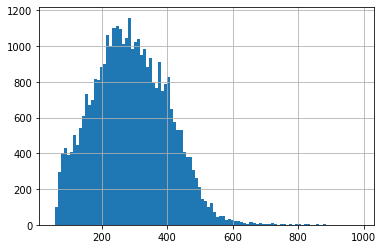

In [11]:
train[train['store'] == 'KaggleMart']['num_sold'].hist(bins=100)

<AxesSubplot:>

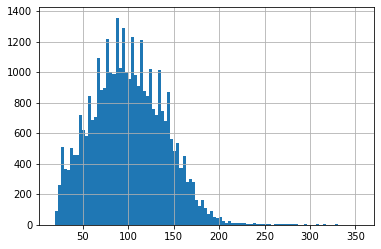

In [12]:
train[train['store'] == 'KaggleRama']['num_sold'].hist(bins=100)

<AxesSubplot:xlabel='store'>

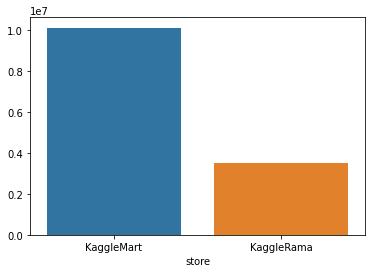

In [13]:
country_sales = train.groupby('country')['num_sold'].sum()

country_sales.sort_values(inplace=True)
sns.barplot(x=country_sales.index, y=country_sales.values)
store_sales = train.groupby('store')['num_sold'].sum()

sns.barplot(x=store_sales.index, y=store_sales.values)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    70128 non-null  int64         
 1   date      70128 non-null  datetime64[ns]
 2   country   70128 non-null  object        
 3   store     70128 non-null  object        
 4   product   70128 non-null  object        
 5   num_sold  70128 non-null  int64         
 6   new_date  70128 non-null  period[M]     
dtypes: datetime64[ns](1), int64(2), object(3), period[M](1)
memory usage: 3.7+ MB


In [15]:
books_over_time_df = []
k=train[train['product'] == 'Kaggle Advanced Techniques'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)
k=train[train['product'] == 'Kaggle Getting Started'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k) 
k=train[train['product'] == 'Kaggle Recipe Book'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)
k=train[train['product'] == 'Kaggle for Kids: One Smart Goose'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)
k=train[train['product'] == 'Kaggle Advanced Techniques'][['new_date','num_sold']]
k = k.groupby('new_date', as_index=False)['num_sold'].sum()
k['new_date'] = k['new_date'].astype('datetime64')
books_over_time_df.append(k)

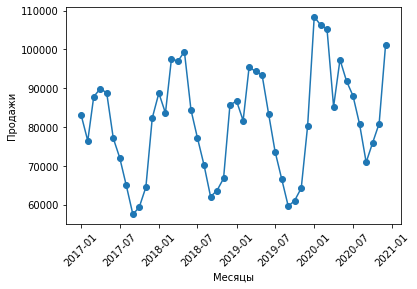

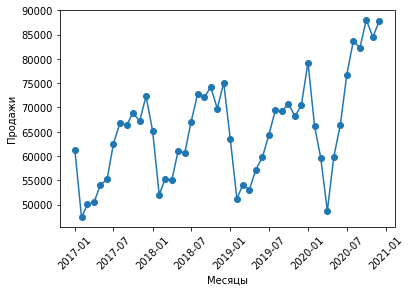

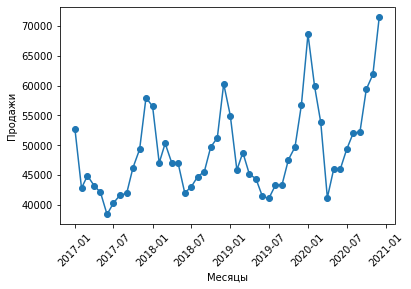

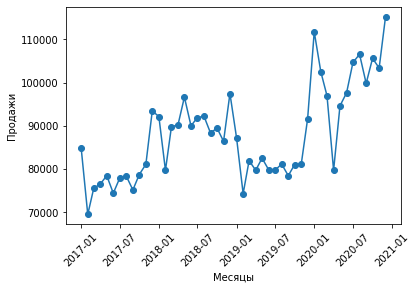

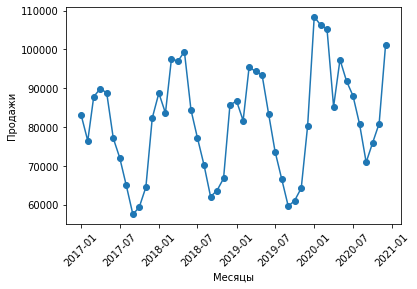

In [16]:
#fig, ax = plt.subplots(3, 2, figsize=(5 ,5))
for i in range(len(books_over_time_df)):
    plt.plot_date('new_date', 'num_sold', data = books_over_time_df[i],linestyle='solid')
    plt.xticks(rotation=45)
    plt.xlabel('Месяцы')
    plt.ylabel('Продажи')
    plt.show()

**Here we can see an obvious seasonality and trend, so we must define a trend for each book or even for each country and each book as a pair, in order to make our predictions more accurate** 

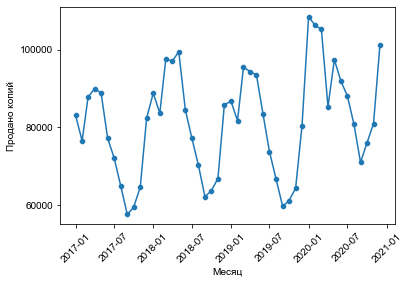

In [17]:
books_over_time_df[0]['new_date'] = books_over_time_df[0]['new_date'].astype('datetime64')
ax = sns.lineplot(data=books_over_time_df[0], x = 'new_date', y = 'num_sold')
sns.scatterplot(data=books_over_time_df[0], x = 'new_date', y = 'num_sold', ax=ax)
ax.set(xlabel='Месяц', ylabel='Продано копий')
sns.set(rc={"figure.figsize":(5, 5)}, font_scale=2)
plt.xticks(rotation=45)
plt.show()

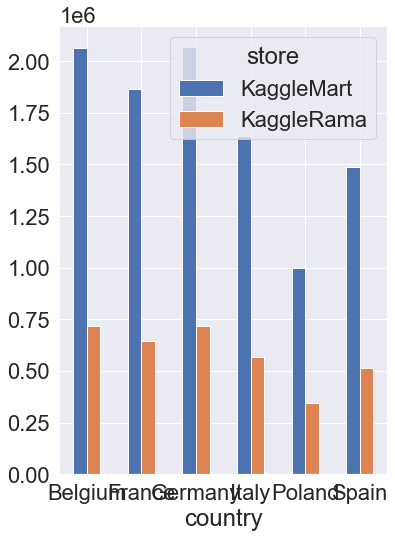

In [18]:
country_store_sales = train.groupby(['store', 'country'])['num_sold'].sum()
country_store_sales.sort_values(inplace=True)

country_store_sales
ax = country_store_sales.unstack(level=0).plot(kind='bar', subplots=False, rot=0, figsize=(6, 8), layout=(4, 6))
plt.tight_layout()

**Lets devide our dataset into 48 different sections, for each country, store, and product**

**FEATURE ENGINEERING**

In [19]:
print(train.head())
X_train = []
X_test = []

#country = Belgium, store = KaggleMart
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Belgium, store = KaggleRama
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Belgium') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = France, store = KaggleMart
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = France, store = KaggleRama
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'France') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Germany, store = KaggleMart
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Germany, store = KaggleRama
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Germany') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Italy, store = KaggleMart
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Italy, store = KaggleRama
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Italy') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Poland, store = KaggleMart
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Poland, store = KaggleRama
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Poland') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Spain, store = KaggleMart
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleMart') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Poland, store = KaggleRama
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Advanced Techniques')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Getting Started')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle Recipe Book')])
X_train.append(train[(train['country'] == 'Spain') & (train['store'] == 'KaggleRama') & (train['product'] == 'Kaggle for Kids: One Smart Goose')])

   row_id       date  country       store                           product  \
0       0 2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1       1 2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2       2 2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3       3 2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4       4 2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   num_sold new_date  
0       663  2017-01  
1       615  2017-01  
2       480  2017-01  
3       710  2017-01  
4       240  2017-01  


In [20]:
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Belgium, store = KaggleRama
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Belgium') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = France, store = KaggleMart
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = France, store = KaggleRama
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'France') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Germany, store = KaggleMart
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Germany, store = KaggleRama
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Germany') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Italy, store = KaggleMart
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Italy, store = KaggleRama
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Italy') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Poland, store = KaggleMart
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Poland, store = KaggleRama
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Poland') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

#country = Spain, store = KaggleMart
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleMart') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])
#country = Poland, store = KaggleRama
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Advanced Techniques')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Getting Started')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle Recipe Book')])
X_test.append(test[(test['country'] == 'Spain') & (test['store'] == 'KaggleRama') & (test['product'] == 'Kaggle for Kids: One Smart Goose')])

In [21]:
X_train[46].head()

,row_id,date,country,store,product,num_sold,new_date
46,46,2017-01-01,Spain,KaggleRama,Kaggle Recipe Book,113,2017-01
94,94,2017-01-02,Spain,KaggleRama,Kaggle Recipe Book,74,2017-01
142,142,2017-01-03,Spain,KaggleRama,Kaggle Recipe Book,69,2017-01
190,190,2017-01-04,Spain,KaggleRama,Kaggle Recipe Book,74,2017-01
238,238,2017-01-05,Spain,KaggleRama,Kaggle Recipe Book,67,2017-01


In [22]:
for i in X_train:
    i.drop(['row_id', 'country', 'store', 'product'], axis=1, inplace=True)
for i in X_test:
    i.drop(['row_id', 'country', 'store', 'product'], axis=1, inplace=True)

C:\Users\Serueja\AppData\Local\Temp\ipykernel_14124\2500610200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i.drop(['row_id', 'country', 'store', 'product'], axis=1, inplace=True)
C:\Users\Serueja\AppData\Local\Temp\ipykernel_14124\2500610200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i.drop(['row_id', 'country', 'store', 'product'], axis=1, inplace=True)
C:\Users\Serueja\AppData\Local\Temp\ipykernel_14124\2500610200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

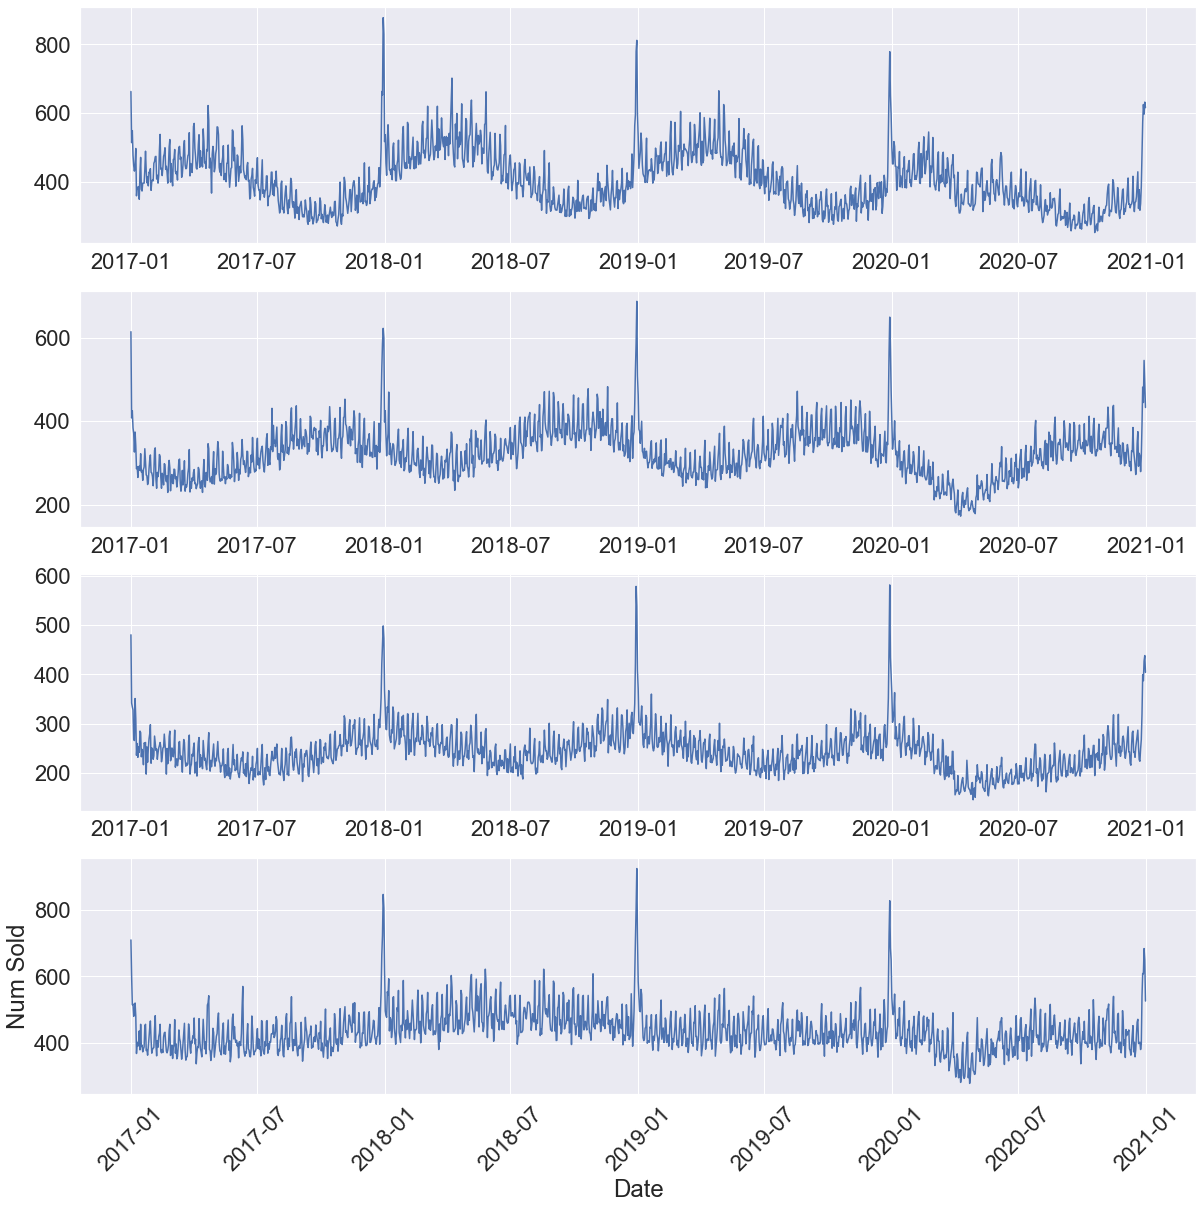

In [23]:
from matplotlib.pyplot import figure, subplot
plt.rcParams["figure.figsize"] = (20,20)
fig, ax = plt.subplots(4)
for i in range(4):
    ax[i].plot('date', 'num_sold', data=X_train[i], linestyle='solid')
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Num Sold')

We now also can and should think of model validation, especially data, which we will use for it. My idea is to chop off a whole year of a train dataset and check SMAPE on that chunk of data, then we could manipulate the hyperparameters and then let our models learn from another year, and only then predict values for test dataset.

In [24]:
X_train_mini = []
X_eval = []

In [25]:
for i in X_train:
    X_train_mini.append(i[i['date'] <= '2020-01-01'])
    X_eval.append(i[i['date'] > '2020-01-01'])

In [26]:
X_train_mini[0]

,date,num_sold,new_date
0,2017-01-01,663,2017-01
48,2017-01-02,514,2017-01
96,2017-01-03,549,2017-01
144,2017-01-04,477,2017-01
192,2017-01-05,447,2017-01
...,...,...,...
52368,2019-12-28,669,2019-12
52416,2019-12-29,779,2019-12
52464,2019-12-30,652,2019-12
52512,2019-12-31,594,2019-12


**Here let's try using from statsmodels.tsa.seasonal.STL**

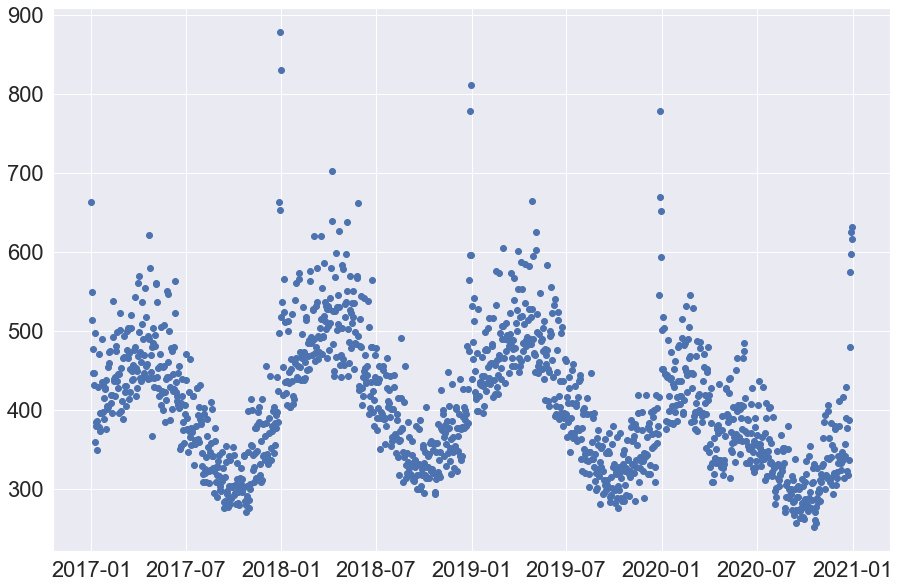

In [27]:
# X_train[0]
plt.rcParams["figure.figsize"] = (15, 10)
plt.plot_date(x=X_train[0]['date'], y=X_train[0]['num_sold'])

**Now we did all the preparations we need, let's dive into modelling**

Here we start with a common practice CalendarFourier and DP. I guess here we could pipelines, but to make things faster I will stick with an ancient and not so pretty way. Hope some day will figure out how to use pipelines here.

**Рубрика эксперименты**

In [28]:
#тут у нас будет дэйт рэндж и календарь Фурье

experiment_date_range = pd.date_range(start='2017-01-01', end='2019-12-31')

experiment_fourier = CalendarFourier(freq='A', order=250)

experiment_dp = DeterministicProcess(
    index=experiment_date_range,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[experiment_fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

experiment_date_range

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=1095, freq='D')

In [29]:
#тут будет сэмпл и аут оф сэмпл + дата для обучения + дата для проверки

experiment_in_sample = experiment_dp.in_sample()

experiment_out_of_sample = experiment_dp.out_of_sample(steps=365)

#data for learning

experiment_train_y = X_train[0][:1095]['num_sold']
experiment_test_y = X_train[0][1096:]['num_sold']

experiment_train_y = experiment_train_y.reset_index()
experiment_train_y.drop('index', axis = 1, inplace=True)
experiment_test_y = experiment_test_y.reset_index()
experiment_test_y.drop('index', axis = 1, inplace=True)

len(experiment_train_y), len(experiment_in_sample), len(experiment_out_of_sample), len(experiment_test_y)

(1095, 1095, 365, 365)

In [37]:
#эта ячейка будет для обучения и валидации модельки
#LinearRegression
experiment_linear_model = LinearRegression(fit_intercept=False)

experiment_linear_model.fit(experiment_in_sample,experiment_train_y)

smape(experiment_linear_model.predict(experiment_out_of_sample), experiment_test_y)

#smape очень высокая, что говорит о переобученности модели

13.000065090588484

XGBoost model

In [39]:
#Let's try XGBoost

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

experiment_xgboost_model = GradientBoostingRegressor(**params)

y_train_for_xgboost = np.array(experiment_train_y)

experiment_xgboost_model.fit(experiment_in_sample, y_train_for_xgboost)

xgboost_predictions = experiment_xgboost_model.predict(experiment_out_of_sample)
xgboost_predictions = pd.Series(xgboost_predictions)

smape(xgboost_predictions, experiment_test_y)

c:\Users\Serueja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


8401.649446187499

Plot of the linear regression prediction

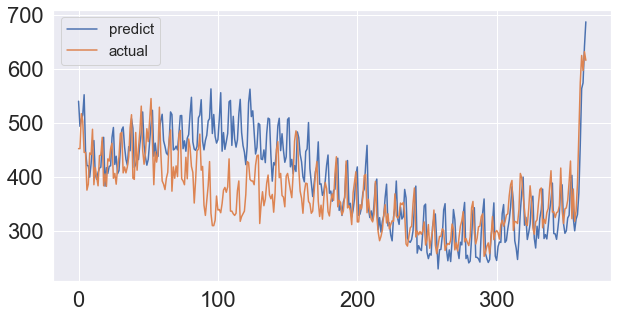

In [35]:
plt.rcParams["figure.figsize"] = (10, 5)

plt.plot(experiment_linear_model.predict(experiment_out_of_sample))
plt.plot(experiment_test_y)
plt.legend(['predict', 'actual'], fontsize=15)

Next cell is plotting XGBoost Regressor prediction

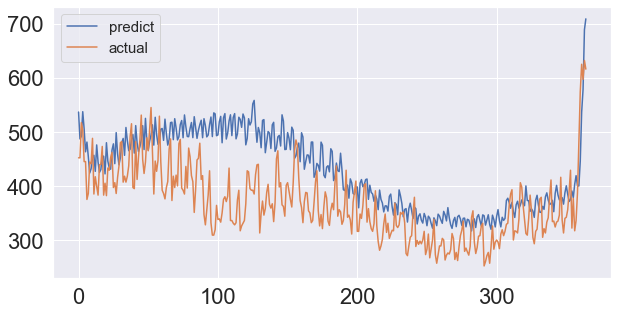

In [40]:
# Plotting XGBoost predictions

plt.rcParams["figure.figsize"] = (10, 5)

plt.plot(xgboost_predictions)
plt.plot(experiment_test_y)
plt.legend(['predict', 'actual'], fontsize=15)

In [ ]:
smape(experiment_linear_model.predict(experiment_in_sample), experiment_train_y)

num_sold    3.948867
dtype: float64

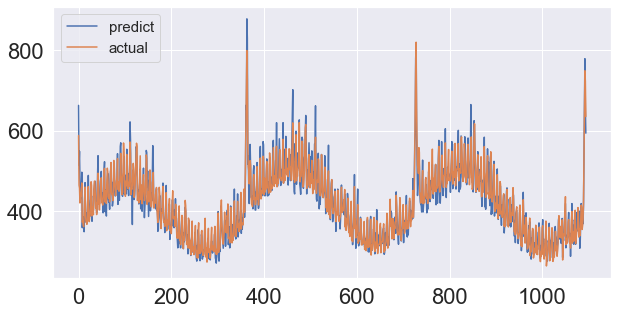

In [ ]:
plt.plot(experiment_train_y)
plt.plot(experiment_linear_model.predict(experiment_in_sample))
plt.legend(['predict', 'actual'], fontsize=15)

**Конец эксперимента**